<a href="https://colab.research.google.com/github/deveshtripath/sih/blob/main/SIH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import os
# os.environ['Kaggle_Plant_data'] = '/content/drive/MyDrive/Kaggle'

In [ ]:
# %cd /content/drive/MyDrive/Kaggle
# !mv .kaggle /root/
# !mkdir .kaggle
# !touch .kaggle/kaggle.json
# ! cp kaggle.json ~/.kaggle/

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d alinedobrovsky/plant-disease-classification-merged-dataset

100% 17.3G/17.3G [03:50<00:00, 126MB/s]
100% 17.3G/17.3G [03:50<00:00, 80.8MB/s]


In [ ]:
# !unzip \*.zip && rm *.zip
import zipfile
zip_ref = zipfile.ZipFile("/content/plant-disease-classification-merged-dataset.zip", 'r')
zip_ref.extractall("/content/data/plant-disease-classification-merged-dataset")
zip_ref.close()

In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
import cv2

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [ ]:
path = '/content/data/plant-disease-classification-merged-dataset'

In [ ]:
# ls

In [ ]:
x = os.listdir(path)
len(x)

88

In [ ]:
image_dir = Path(path)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.PNG')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
image_df.shape

(79084, 2)

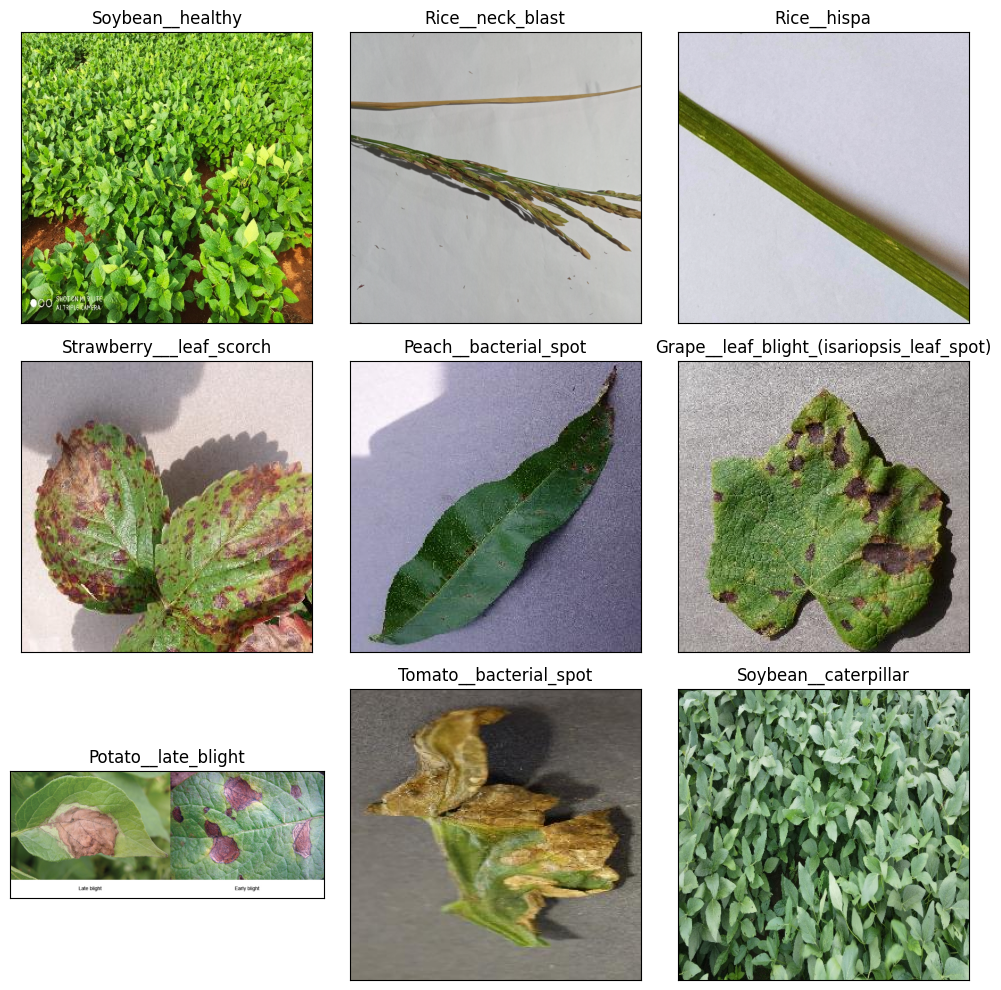

In [ ]:
# Display
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [ ]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input,validation_split=0.2)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

Found 50614 validated image filenames belonging to 88 classes.
Found 12653 validated image filenames belonging to 88 classes.
Found 15817 validated image filenames belonging to 87 classes.


In [ ]:
image_batch, label_batch = next(val_images)
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 88))

In [ ]:
pre_trained_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

for layer in pre_trained_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# Create checkpoint callback
checkpoint_path = "disease_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 5,
                               restore_best_weights = True)

In [ ]:
def output_of_last_layer(pre_trained_model):
  last_desired_layer = pre_trained_model.get_layer('conv5_block3_out')
  last_output = last_desired_layer.output
  return last_output

In [ ]:
last_output = output_of_last_layer(pre_trained_model)

In [ ]:
x = layers.GlobalAveragePooling2D()(last_output)

x =tf.keras.layers.Dense(units=512, activation='relu')(x)
x =tf.keras.layers.Dropout(0.2)(x)
x =tf.keras.layers.Dense(units=256, activation='relu')(x)
x =tf.keras.layers.Dropout(0.2)(x)
x =tf.keras.layers.Dense(units=128, activation='relu')(x)
x =tf.keras.layers.Dense(units=88, activation='softmax')(x)

  # Create the complete model by using the Model class
model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
model.compile(optimizer = 'adam',
                loss ='categorical_crossentropy',
                metrics = ['accuracy'])

In [ ]:
total_params = model.count_params()
num_trainable_params = sum([w.shape.anum_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 24,812,376 total parameters in this model.
There are 1,224,664 trainable parameters in this model.


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
hist = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=5,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

Epoch 1/5
1582/1582 [==============================] - 899s 559ms/step - loss: 0.7302 - accuracy: 0.7772 - val_loss: 0.3540 - val_accuracy: 0.8748
Epoch 2/5
1582/1582 [==============================] - 855s 541ms/step - loss: 0.3808 - accuracy: 0.8696 - val_loss: 0.2900 - val_accuracy: 0.8990
Epoch 3/5
1582/1582 [==============================] - 886s 560ms/step - loss: 0.3130 - accuracy: 0.8931 - val_loss: 0.2661 - val_accuracy: 0.9067
Epoch 4/5
1582/1582 [==============================] - 903s 571ms/step - loss: 0.2815 - accuracy: 0.9035 - val_loss: 0.2491 - val_accuracy: 0.9158
Epoch 5/5
1582/1582 [==============================] - 864s 546ms/step - loss: 0.2552 - accuracy: 0.9137 - val_loss: 0.2293 - val_accuracy: 0.9229


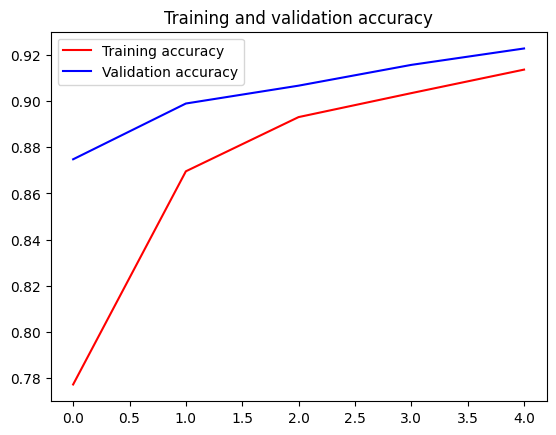

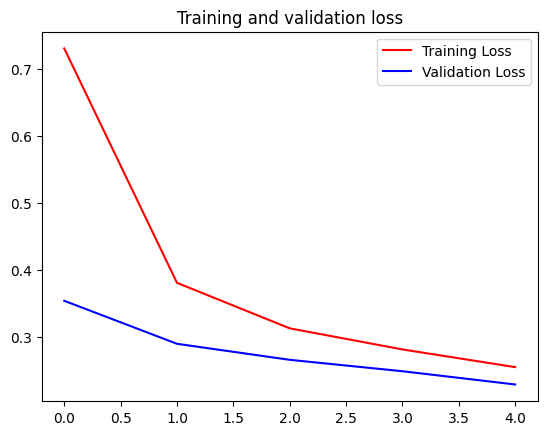

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
## creating new model

x = layers.GlobalAveragePooling2D()(last_output)

x =tf.keras.layers.Dense(units=512, activation='relu')(x)
x =tf.keras.layers.Dropout(0.2)(x)
x =tf.keras.layers.Dense(units=256, activation='relu')(x)
x =tf.keras.layers.Dropout(0.2)(x)
x =tf.keras.layers.Dense(units=256, activation='relu')(x)
x =tf.keras.layers.Dropout(0.2)(x)
x =tf.keras.layers.Dense(units=128, activation='relu')(x)
x =tf.keras.layers.Dense(units=88, activation='softmax')(x)

  # Create the complete model by using the Model class
model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
model.compile(optimizer = 'adam',
                loss ='categorical_crossentropy',
                metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
hist = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=5,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

Epoch 1/5
1582/1582 [==============================] - 916s 574ms/step - loss: 0.8599 - accuracy: 0.7437 - val_loss: 0.4191 - val_accuracy: 0.8564
Epoch 2/5
1582/1582 [==============================] - 880s 556ms/step - loss: 0.4389 - accuracy: 0.8562 - val_loss: 0.3046 - val_accuracy: 0.8955
Epoch 3/5
1582/1582 [==============================] - 874s 552ms/step - loss: 0.3641 - accuracy: 0.8780 - val_loss: 0.2924 - val_accuracy: 0.8999
Epoch 4/5
1582/1582 [==============================] - 910s 576ms/step - loss: 0.3216 - accuracy: 0.8942 - val_loss: 0.3116 - val_accuracy: 0.9013
Epoch 5/5
1582/1582 [==============================] - 859s 543ms/step - loss: 0.2977 - accuracy: 0.9018 - val_loss: 0.2806 - val_accuracy: 0.9060


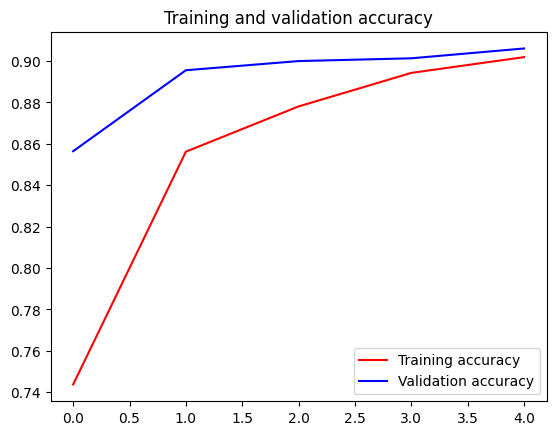

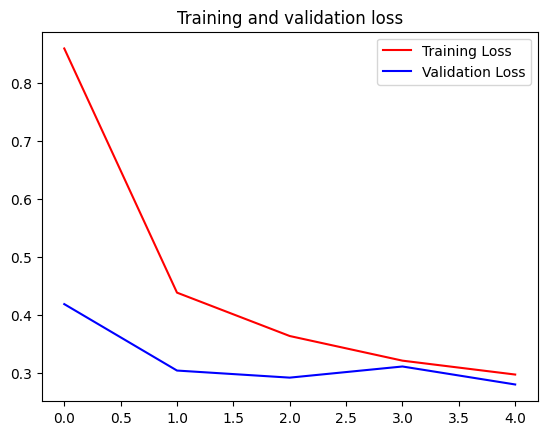

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

Found 15817 validated image filenames belonging to 88 classes.


In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.29715
Test Accuracy: 90.42%


In [ ]:
results = model.predict(test_images, verbose=0)

In [ ]:
results

array([[1.0925682e-19, 3.0148543e-15, 1.7561155e-15, ..., 1.3097225e-07,
        9.9999392e-01, 5.7875063e-06],
       [1.8081352e-07, 5.8141870e-07, 5.9464444e-05, ..., 1.0696732e-04,
        6.9077751e-06, 9.1170674e-05],
       [3.4499355e-06, 2.2355249e-07, 2.4136511e-06, ..., 3.2077894e-09,
        1.5225373e-14, 1.3440942e-09],
       ...,
       [9.7008469e-12, 5.0202775e-09, 8.5362906e-10, ..., 1.5014481e-11,
        2.0171913e-12, 3.2800287e-10],
       [3.1757343e-09, 3.1800521e-06, 9.1735135e-09, ..., 2.4773591e-08,
        3.6998142e-14, 5.5980758e-11],
       [2.2783681e-05, 3.5962553e-06, 9.9345398e-01, ..., 1.9400470e-10,
        1.2443155e-11, 8.6571932e-09]], dtype=float32)

In [ ]:
# x = layers.GlobalAveragePooling2D()(last_output)

# x =tf.keras.layers.Dense(units=512, activation='relu')(x)
# x =tf.keras.layers.Dropout(0.2)(x)
# x =tf.keras.layers.Dense(units=256, activation='relu')(x)
# x =tf.keras.layers.Dropout(0.2)(x)
# x =tf.keras.layers.Dense(units=128, activation='relu')(x)
# x =tf.keras.layers.Dense(units=88, activation='softmax')(x)

#   # Create the complete model by using the Model class
# model = Model(inputs=pre_trained_model.input, outputs=x)

#   # Compile the model
# model.compile(optimizer = 'adam',
#                 loss ='categorical_crossentropy',
#                 metrics = ['accuracy'])


def build_model(hp):
  x = layers.GlobalAveragePooling2D()(last_output)
  counter = 0
  for i in range(hp.Int('num_layers', min_value=1, max_value=10)):
    if(counter == 0):
      tf.keras.layers.Dense(
              hp.Int('units'+str(i), min_value=8,max_value=512, step=8),
              activation=hp.Choice('activation'+str(i), values=['relu','tanh','sigmoid']), input_dim=8
      )
      tf.keras.layers.Dropout(hp.Choice('dropout'+str(i), values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
    else:
      tf.keras.layers.Dense(
              hp.Int('units'+str(i), min_value=8,max_value=256, step=8),
              activation=hp.Choice('activation'+str(i), values=['relu','tanh','sigmoid'])
      )
      tf.keras.layers.Dropout(hp.Choice('dropout'+str(i), values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
    counter+=1

  tf.keras.layers.Dense(88, activation='sigmoid')

  model = Model(inputs=pre_trained_model.input, outputs=x)

  model.compile(optimizer=hp.Choice('optimizer',values=['rmsprop','adam','sgd','nadam','adadelta']),
                loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
# !pip install -U keras-tuner
# import kerastuner as kt

In [ ]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras import layers
from tensorflow.keras import Model

def build_model(hp):
    x = layers.GlobalAveragePooling2D()(last_output)

    for i in range(hp.Int('num_layers', min_value=1, max_value=10)):
        units = hp.Int('units_' + str(i), min_value=8, max_value=512, step=8)
        activation = hp.Choice('activation_' + str(i), values=['relu', 'tanh', 'sigmoid'])
        dropout = hp.Choice('dropout_' + str(i), values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

        if i == 0:
            x = layers.Dense(units, activation=activation, input_dim=8)(x)
            x = layers.Dropout(dropout)(x)
        else:
            x = layers.Dense(units, activation=activation)(x)
            x = layers.Dropout(dropout)(x)

    output_layer = layers.Dense(88, activation='sigmoid')(x)

    model = Model(inputs=pre_trained_model.input, outputs=output_layer)

    optimizer = hp.Choice('optimizer', values=['rmsprop', 'adam', 'sgd', 'nadam', 'adadelta'])

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Define the Hyperband tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # You can adjust this value as needed
    directory='my_tuning_dir',  # Change to your desired directory
    project_name='my_tuning_project'
)

# Perform the hyperparameter search
tuner.search(train_images, steps_per_epoch=len(train_images), validation_data=val_images,validation_steps=len(val_images), epochs=5)  # Adjust the number of epochs as needed



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
10                |10                |num_layers
344               |344               |units_0
tanh              |tanh              |activation_0
0.2               |0.2               |dropout_0
nadam             |nadam             |optimizer

Epoch 1/5
 537/1582 [=========>....................] - ETA: 1:56:01 - loss: 0.1770 - accuracy: 0.0942

In [ ]:
tuner.get_best_hyperparameters()[0].values

In [ ]:
model = tuner.get_best_models(num_models=1)[0]